In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
BASE_DIR = "../MachineLearningCSV/MachineLearningCVE/"
all_files = os.listdir(BASE_DIR)

df = pd.read_csv(f"{BASE_DIR}{all_files[0]}")

print(df.shape)
for i in all_files[1:]:
    print(i)
    df_ = pd.read_csv(f"{BASE_DIR}{i}")
    print(df_.shape)
    df = pd.concat([df,df_])
    print(df.shape)

df.columns = [i.strip().replace(" ","_") for i in df.columns]
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

j = 0
label_dict = {}
for k,i in df.iloc[:,-1].value_counts().items():
    label_dict[k] = j
    j += 1

def label_mapper(r,info=label_dict):
    return info[r]  
df['Label'] = df['Label'].apply(label_mapper)

(225745, 79)
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
(286467, 79)
(512212, 79)
Friday-WorkingHours-Morning.pcap_ISCX.csv
(191033, 79)
(703245, 79)
Monday-WorkingHours.pcap_ISCX.csv
(529918, 79)
(1233163, 79)
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
(288602, 79)
(1521765, 79)
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
(170366, 79)
(1692131, 79)
Tuesday-WorkingHours.pcap_ISCX.csv
(445909, 79)
(2138040, 79)
Wednesday-workingHours.pcap_ISCX.csv
(692703, 79)
(2830743, 79)


In [3]:
label_dict

{'BENIGN': 0,
 'DoS Hulk': 1,
 'DDoS': 2,
 'PortScan': 3,
 'DoS GoldenEye': 4,
 'FTP-Patator': 5,
 'DoS slowloris': 6,
 'DoS Slowhttptest': 7,
 'SSH-Patator': 8,
 'Bot': 9,
 'Web Attack � Brute Force': 10,
 'Web Attack � XSS': 11,
 'Infiltration': 12,
 'Web Attack � Sql Injection': 13,
 'Heartbleed': 14}

In [4]:
df.Label.value_counts()

0     2096484
1      172849
2      128016
3       90819
4       10286
5        5933
6        5385
7        5228
8        3219
9        1953
10       1470
11        652
12         36
13         21
14         11
Name: Label, dtype: int64

In [5]:
LEARNING_RATE = 0.001
EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = int(BATCH_SIZE * 10)
NON_ZERO_DAY_CLASSES = list(np.array([1,2,3,4,5,6,7,8,9,10,11])-1)

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(),inplace=True)

df_ = df[df.Label.isin(NON_ZERO_DAY_CLASSES)]

X = df_.iloc[:,:-1]
y = df_.iloc[:,-1]
y[y!=0] = 1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

zero = df[~df.Label.isin(NON_ZERO_DAY_CLASSES)]
X_zero = zero.iloc[:,:-1]
y_zero = np.ones(X_zero.shape[0])

C:\Users\axylo\AppData\Local\Temp\ipykernel_2784\4035843089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0] = 1


In [7]:
ls = len(y_train[y_train == 1])

In [8]:
print(np.unique(y_train,return_counts=True))
undersample = RandomUnderSampler(sampling_strategy={0 : int(ls + ls * 0.3),1:ls})
X_train_d, y_train_d = undersample.fit_resample(X_train, y_train)
print(np.unique(y_train_d,return_counts=True))

(array([0, 1], dtype=int64), array([1677228,  340085], dtype=int64))
(array([0, 1], dtype=int64), array([442110, 340085], dtype=int64))


In [9]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train_d)
X_valid_sc = sc.transform(X_valid)
X_zero_sc = sc.transform(X_zero)

In [10]:
tem = X_valid_sc[y_valid==0]
X_test_sc = np.concatenate((tem, X_zero_sc), axis=0)
y_test = np.concatenate((np.zeros(tem.shape[0]),np.ones(X_zero_sc.shape[0])))

In [11]:
X_train_sc, y_train_d = shuffle(X_train_sc, y_train_d)
X_valid_sc, y_valid = shuffle(X_valid_sc, y_valid.values)
X_test_sc, y_test = shuffle(X_test_sc, y_test)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sc,y_train_d))
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_sc, y_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_sc, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
class AccentuatedLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, kernels, name=None):
        super(AccentuatedLayer, self).__init__(name=name)
        self.emb_dim = emb_dim
        self.projected_emb = tf.keras.layers.Dense(emb_dim, activation='tanh', trainable=True)
        self.pattern_kernels = tf.Variable(tf.random_normal_initializer()(shape=[kernels,emb_dim], dtype=tf.float32)
                                           ,trainable=True)
    
    def compute_cosine_sim(self, a, b):
        normalize_a = tf.nn.l2_normalize(a,1)        
        normalize_b = tf.nn.l2_normalize(b,1)
        sim = tf.matmul(normalize_a, normalize_b, transpose_b=True)
        return sim
    
    def call(self, inputs, hidden_smx=None):
        embs = self.projected_emb(inputs)
        similarity = self.compute_cosine_sim(embs,self.pattern_kernels)
        smx = tf.math.softmax(similarity)
        if hidden_smx is None:
            cell_outs = tf.einsum('ij,ik->ikj', embs, smx)
            return cell_outs, smx
        else:
            sidx = tf.argsort(hidden_smx)
            weighted_scores = tf.gather(tf.cumsum(tf.sort(hidden_smx,axis=1),axis=1),sidx,axis=1, batch_dims = 1)
            sofsm = tf.einsum("ij,ijk->ijk",weighted_scores,smx)
            cell_outs = tf.reduce_sum(tf.einsum("ijk,ijl->ijlk",embs,sofsm),axis=1)
            return cell_outs, tf.reduce_sum(smx,axis=1)

In [14]:
inp_layer = tf.keras.layers.Input(shape=(X_test_sc.shape[1],))

ac_vec, hid= AccentuatedLayer(32,kernels=16,name=f"AccentLayer1")(inp_layer)
ac_vec, hid = AccentuatedLayer(16,kernels=8,name=f"AccentLayer2")(ac_vec, hid)
dp = tf.keras.layers.Dropout(0.2)(ac_vec)

flt = tf.keras.layers.Flatten()(dp)
outl = tf.keras.layers.Dense(1,activation='sigmoid')(flt)

model = tf.keras.Model(inputs=inp_layer,outputs=outl)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
AccentLayer1 (AccentuatedLayer) ((None, 16, 32), (No 3040        input_1[0][0]                    
__________________________________________________________________________________________________
AccentLayer2 (AccentuatedLayer) ((None, 8, 16), (Non 656         AccentLayer1[0][0]               
                                                                 AccentLayer1[0][1]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 16)        0           AccentLayer2[0][0]           

In [17]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),metrics=['acc'])

In [18]:
history = model.fit(train_dataset,epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/5
12222/12222 [==============================] - 180s 14ms/step - loss: 0.1399 - acc: 0.9469 - val_loss: 0.0977 - val_acc: 0.9478
Epoch 2/5
12222/12222 [==============================] - 166s 14ms/step - loss: 0.0963 - acc: 0.9634 - val_loss: 0.0723 - val_acc: 0.9703
Epoch 3/5
12222/12222 [==============================] - 178s 15ms/step - loss: 0.0784 - acc: 0.9716 - val_loss: 0.0545 - val_acc: 0.9757
Epoch 4/5
12222/12222 [==============================] - 175s 14ms/step - loss: 0.0680 - acc: 0.9756 - val_loss: 0.0631 - val_acc: 0.9729
Epoch 5/5
12222/12222 [==============================] - 162s 13ms/step - loss: 0.0628 - acc: 0.9771 - val_loss: 0.0501 - val_acc: 0.9740


In [19]:
y_valid_pred = np.array(model.predict(valid_dataset)>0.5,dtype=np.int32)

In [20]:
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    419256
           1       0.88      0.98      0.93     85073

    accuracy                           0.97    504329
   macro avg       0.94      0.97      0.96    504329
weighted avg       0.98      0.97      0.97    504329



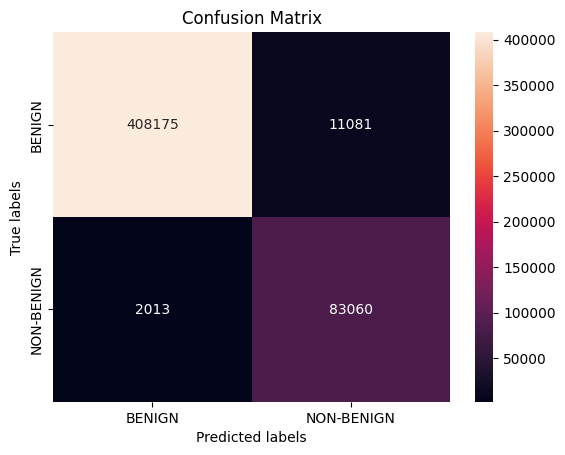

In [21]:
cm = confusion_matrix(y_valid,y_valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

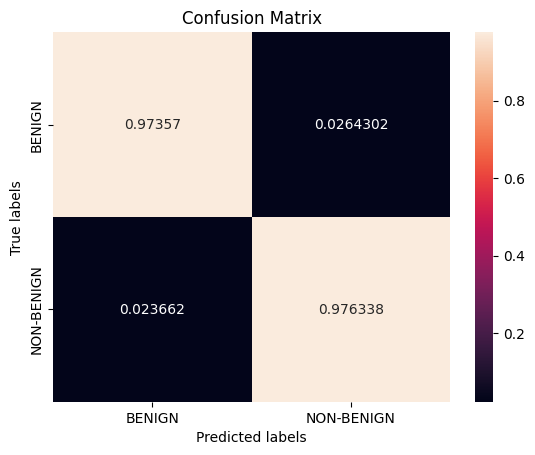

In [22]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [23]:
y_test_pred_prob = model.predict(test_dataset)

In [34]:
y_test_pred = np.array(y_test_pred_prob>0.5,dtype=np.int32)

In [35]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    419256
         1.0       0.05      0.85      0.10       720

    accuracy                           0.97    419976
   macro avg       0.53      0.91      0.54    419976
weighted avg       1.00      0.97      0.98    419976



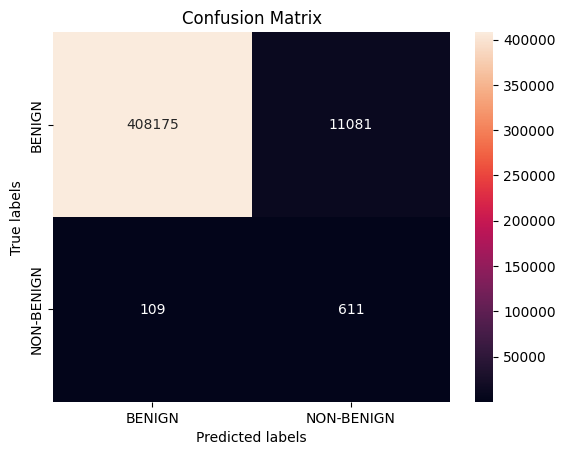

In [36]:
cm = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

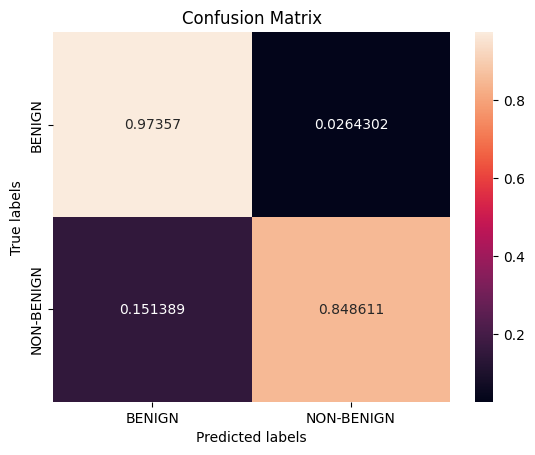

In [37]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);